In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT, PhaseGate, HGate
from qiskit.quantum_info import Operator
from math import log, ceil, floor, pi
# Computes (a+b) in fourier space given that qft has been 
# applied to the n bits of b before entering the circuit
def fourier_add_a(a, n_qubits, msb_top=True):
    n_a_bits = 1 if a == 0 else floor(log(a, 2)) + 1
    f_add_circ = QuantumCircuit(n_qubits)
    # Create and add classical-bit-wise controlled operators    
    for j in range(n_qubits-1, -1, -1):
        cp_a = a
        phase = 0
        for i in range(1, n_qubits - j + 1):
            if cp_a % 2 == 1:
                #add a phase shift gate index i
                phase += 2 * pi / (2**(n_qubits - j - i + 1))
            cp_a = cp_a >> 1
        phase_gate = PhaseGate(phase)
        if msb_top:
            f_add_circ.append(phase_gate, [j]) 
        else:
            f_add_circ.append(phase_gate, [n_qubits - j - 1])
    return f_add_circ

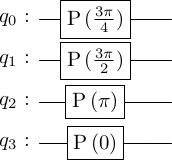

In [3]:
fourier_add_a(6, 4).draw("latex")

In [39]:
# Initializes binary representation of x using n qubits, highest
# order qubit at the top.
def init_x_circuit(x, n_qubits, msb_top=True):
    x_circuit = QuantumCircuit(n_qubits)
    for i in range(n_qubits-1, -1, -1):
        bit = x % 2
        if bit == 1:
            if msb_top:
                x_circuit.x(i) 
            else:
                x_circuit.x(n_qubits - i - 1)
        x = x >> 1
    return x_circuit
        

In [40]:
def swap_circuit(n_qubits):
    swap_circuit = QuantumCircuit(n_qubits)
    for i in range(0, floor(n_qubits/2)):
        swap_circuit.swap(i, n_qubits - i - 1)
    return swap_circuit

In [41]:
def msb_top_qft(n_qubits):
    qft = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        qft.h(i)
        for j in range(n_qubits - i, 1, -1):
            phase = 2 * pi / (2**j)
            phase_gate = PhaseGate(phase)
            ctrl_phase_gate = phase_gate.control(1)
            qft.append(ctrl_phase_gate, [n_qubits - j + 1, i])
    return qft

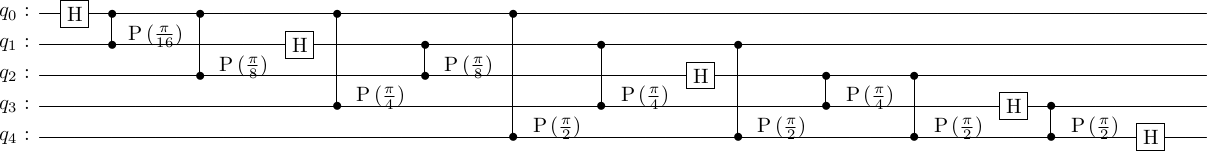

In [42]:
msb_top_qft(5).draw("latex")

In [43]:
def qft_adder(a, b, n, keep_carry=True, msb_top=True):
    if keep_carry:
        n += 1
    qft_adder_circ = QuantumCircuit(n)
    qft_adder_circ.append(init_x_circuit(b, n, msb_top).to_gate(label=f"INIT({b})"), range(n))
    if msb_top:
        qft_adder_circ.append(msb_top_qft(n).to_gate(label="QFT"), range(n))
    else:
        qft_adder_circ.append(QFT(n, do_swaps=False), range(n))
    qft_adder_circ.append(fourier_add_a(a, n, msb_top).to_gate(label=f"\Phi ADD({a})"), range(n))
    if msb_top:
        qft_adder_circ.append(msb_top_qft(n).inverse().to_gate(label="IQFT"), range(n))
    else:
        qft_adder_circ.append(QFT(n, inverse=True, do_swaps=False), range(n))
    return qft_adder_circ

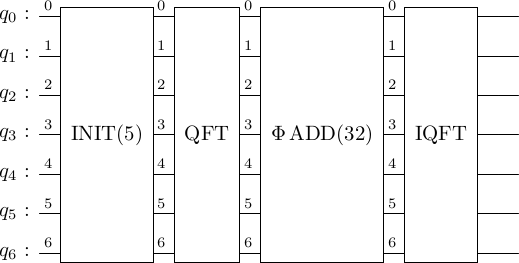

In [46]:
qft_adder(32,5, floor(log(32, 2)) + 1, msb_top=False).draw("latex")

In [ ]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

" Inputs and Options"
a = 30
b = 5
n = floor(log(b, 2))+2 #if (a>=b) else floor(log(b, 2))+2
msb_top = False # Order qubits such that most significant is on top

""" Create the circuit"""
qft_adder_example = QuantumCircuit(n,n)
qft_adder_example.append(qft_adder(a, b, n, False,msb_top=msb_top,), range(n))
if msb_top:
    qft_adder_example.append(swap_circuit(n).to_gate(label="SWAP"), range(n))
qft_adder_example.measure(range(n), range(n))


""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(qft_adder_example, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=1)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

In [47]:
def c2_qft_mod_adder(a, N, n_qubits):
    msb_top=False
    """ Prepare gates"""
    c2_f_add_a = fourier_add_a(a, n_qubits, msb_top).to_gate(label=f"\Phi ADD({a})").control(2)
    c2_f_sub_a = fourier_add_a(a, n_qubits, msb_top).inverse().to_gate(label=f"\Phi SUB({a})").control(2)
    c1_f_add_N = fourier_add_a(N, n_qubits, msb_top).to_gate(label=f"\Phi ADD({N})").control(1)
    f_sub_N = fourier_add_a(N, n_qubits, msb_top).inverse().to_gate(label=f"\Phi SUB({N})")
    """ Construct circuit"""
    # n qubits + 1 ancilla + 2 control 
    c2fma_circ = QuantumCircuit(
        QuantumRegister(2, name="control"),
        QuantumRegister(n_qubits, name="b"),  
        QuantumRegister(1, name="ancilla")
    )
    # controlled ADD a
    c2fma_circ.append(c2_f_add_a, range(n_qubits + 2))
    # SUB N
    c2fma_circ.append(f_sub_N, [i+2 for i in range(n_qubits)])
    # QFT dagger
    c2fma_circ.append(QFT(n_qubits, do_swaps=False, inverse=True).to_gate(), [i+2 for i in range(n_qubits)])
    # set ancilla
    c2fma_circ.cx(n_qubits + 2 - 1, n_qubits + 2 + 1 - 1)
    # QFT
    c2fma_circ.append(QFT(n_qubits, do_swaps=False, inverse=False).to_gate(), [i+2 for i in range(n_qubits)])
    # ancilla controlled ADD N
    allocs = [i+1 for i in range(n_qubits + 1)]
    allocs[0] = n_qubits + 2 + 1 - 1
    c2fma_circ.append(c1_f_add_N, allocs)
    # controlled ADD a
    c2fma_circ.append(c2_f_sub_a, range(n_qubits + 2))
    # QFT dagger
    c2fma_circ.append(QFT(n_qubits, do_swaps=False, inverse=True).to_gate(), [i+2 for i in range(n_qubits)])
    # set ancilla
    c2fma_circ.x(n_qubits + 2 - 1)
    c2fma_circ.cx(n_qubits + 2 - 1, n_qubits + 2 + 1 - 1)
    c2fma_circ.x(n_qubits + 2 - 1)
    # QFT
    c2fma_circ.append(QFT(n_qubits, do_swaps=False, inverse=False).to_gate(), [i+2 for i in range(n_qubits)])
    # controlled ADD a
    c2fma_circ.append(c2_f_add_a, range(n_qubits + 2))
    
    return c2fma_circ

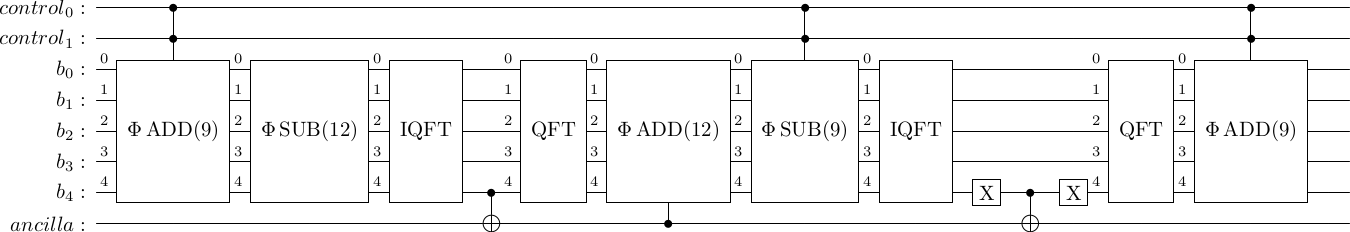

In [50]:
a = 9
b = 7
N = 12
n = floor(log(N, 2)) + 2
c2_qft_mod_adder(a, N, n).draw("latex")

In [73]:
def mod_adder_example(a, b, N):
    high = max(max(a, b), N)
    n_qubits = floor(log(high, 2)) + 5
    example_circ = QuantumCircuit(
        QuantumRegister(2, name="control"),
        QuantumRegister(n_qubits, name="b"),  
        QuantumRegister(1, name="ancilla"), 
        ClassicalRegister(n_qubits, name="readout")
    )
    example_circ.x([0, 1])
    example_circ.append(init_x_circuit(b, n_qubits, False).to_gate(label=f"INIT({b})"), [i+2 for i in range(n_qubits)])
    example_circ.append(QFT(n_qubits, do_swaps=False).to_gate(), [i+2 for i in range(n_qubits)])
    example_circ.append(c2_qft_mod_adder(a, N, n_qubits).to_gate(label=f"\Phi ADD({a})MOD({N})"), range(n_qubits + 2 + 1))
    example_circ.append(QFT(n_qubits, do_swaps=False, inverse=True).to_gate(), [i+2 for i in range(n_qubits)])
    example_circ.measure([i+2 for i in range(n_qubits)], [i for i in range(n_qubits)])
    return example_circ

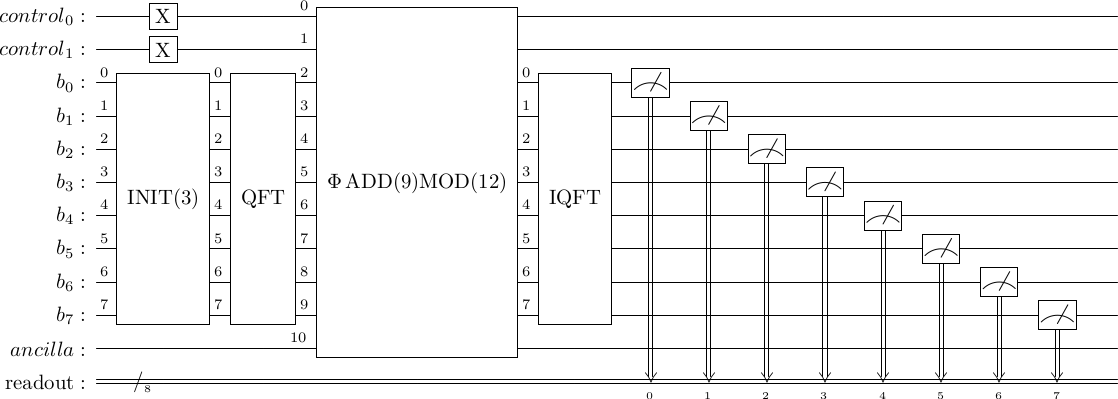

In [74]:
mod_adder_example(9, 3, 12).draw("latex")

In [75]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile
    
""" Create the circuit"""
mod_adder_example_circ = mod_adder_example(8, 0, 13)

""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(mod_adder_example_circ, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=1)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

{'00001000': 1}

In [ ]:
print("done")